<style>
@import url(https://www.numfys.net/static/css/nbstyle.css);
</style>
<a href="https://www.numfys.net"><img class="logo" /></a>

# Precession of Mercury

### Examples - Astrophysics
<section class="post-meta">
By Eilif Sommer Øyre, Jonas Tjemsland and Jon Andreas Støvneng
</section>
Last edited: April 28th 2018 
___

In this notebook we will discuss the general relativistic precession of the orbit of Mercury around the Sun. We will be using the concepts and formulas introduced and derived in the notebook on [General Relativity](https://nbviewer.jupyter.org/urls/www.numfys.net/media/notebooks/GR.ipynb).

The perihelion of Mercury's orbit advances by 5300 arc seconds per century, but only $\sim 5260$ arcseconds can be accounted for by Newtonian effects [1]. Our goal in this notebook is to check if general relativity can account for the last $\sim 40$ arcseconds.

Note that the correction is quite small, and we cannot therefore proceed naively by computing the orbit of Mercury for one century (or one period) and check the precession. In this notebook, we will compute the precession for a set of orbits with a higher precession rate, perform linear regression and extrapolate the precession of Mercury. When the expression is small, the precession rate can be approximated by an analytical expression. This will be discussed at the end of the notebook.

We start by importing packages, setting figure parameters and defining some physical constants.

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from scipy.optimize import curve_fit
import time
%matplotlib inline

In [2]:
# Set common figure parameters
newparams = {'figure.figsize': (16, 6), 'axes.grid': True,
             'lines.linewidth': 1.5, 'lines.markersize': 10,
             'font.size': 14}
plt.rcParams.update(newparams)

# Some constants
AU = 149597870700  # m. Astronomical Unit. Avg. distance Earth Sun
T = 365.25*3600*24 # s. 1 year
c = 299792458      # AU/yr. Speed of light
G = 6.67408e-11    # m^3/kg s^2. Gravitational constant
M = 1.989e30       # kg. Solar mass

### Dimensionless Equation of Motion
It can be shown (see our notebook on [General Relativity](https://nbviewer.jupyter.org/urls/www.numfys.net/media/notebooks/GR.ipynb) or ref. [2]) that the force on a planet of mass $m\ll M$ outside a spherically symmetric mass distribution of mass $M$ is given by

\begin{equation}
\mathbf F =-\frac{GMm}{r^3}\mathbf r\left(1 + \frac{3l^2}{c^2r^2}\right),
\label{eq:force}
\end{equation}

where $G$ is the Newtonian gravitational constant, $\vec r = (x, y, z)$ is the distance to the center of the mass distribution, $l$ is the angular momentum per unit mass and $c$ is the speed of light. The orbiting planet will be restricted to a single plane due to conservation of angular momentum. We can thus restrict the discussions to the $xy$-plane.

Let $R=1\,\mathrm{AU}$ be the distance between the Earth and the Sun, $T=1\,\mathrm{year}$, $m$ be the mass of Mercury and $M$ the mass of the Sun. Define $t_0\equiv t/T$, $\rho\equiv r/R$, $X\equiv x/R$ and $Y\equiv y/R$. We can in this case write equation \eqref{eq:force} on the dimensionless form

\begin{equation}
\frac{\mathrm{d}^2}{\mathrm{d}t_0^2}\left(X, Y\right) =-\frac{GMT^2}{R^3}\frac{\left(X, Y\right)}{\rho^3}\left(1+\frac{3l^2}{R^2c^2\rho^2}\right)\equiv -A\frac{\left(X, Y\right)}{\rho^3}\left(1+\frac{B}{\rho^2}\right).
\label{eq:dimless}
\end{equation}

### Finding $A$ and $B$

By using Kepler's laws (see e.g. [1]), it is easy to show that

$$M_\odot =\frac{4\pi^2\cdot R^3}{G\cdot T^2}.$$

The constant $A$ is thus
$$A = 4\pi^2.$$

In [3]:
A = 4*np.pi**2

In order to find $B$, we must first find a value for the angular momentum (per unit mass) $l$. In doing so, we will need the following data [3]:

| Mercury        | |
| ------------- |:-------------:|
| Perihelion (closest distance to the Sun) | 0.307 499 AU  | 
| Aphelion (farthest distance to the Sun)  | 0.466 697 AU  |
| Orbital period                           | 0.240 846 yr  |
| Max. orbital speed                       | 58.98 km/s    |
| Min. orbital speed                       | 38.86 km/s    |

At the perihelion, the velocity is at its maximum. At the aphelion it is at its minimum. In both cases, the velocity is normal to the distance vector between the Sun and Mercury. The angular momentum per unit mass $l=|\vec v\times \vec r|$ is thus given by

$$l = v_\mathrm{max}\cdot r_\mathrm{min}=v_\mathrm{min}\cdot r_\mathrm{max}.$$

In [4]:
perihelion = 0.307499*AU # m
aphelion = 0.466697*AU   # m
maxVel = 58.98*1000      # m/s
minVel = 38.86*1000      # m/s
l1 = aphelion*minVel
l2 = perihelion*maxVel
print("l = %.5e c^2 = %.5e c^2"%(l1/c**2, l2/c**2))
l = (l1 + l2)/2

l = 3.01871e-02 c^2 = 3.01879e-02 c^2


Let's compute the constant $B$.

In [5]:
B = 3*l**2/(c*AU)**2
print("B = %.3e"%(B))

B = 1.098e-08


This is a small number, which means that the general relativistic correction to the Newtonian orbit is small. Since the correction is this small, the problem can be threated as a perturbation and "solved" analytically (see discussion at the end of this notebook).

In fact, if we continue naively by computing the orbit of Mercury using equation \eqref{eq:dimless} we will get a wrong precession rate due to numerical rounding errors. We will therefore consider different values for $B$, perform regression and extract the precession rate for the correct $B$.

### Numerical Implementation

We now implement the same code as in the [General Relativity](https://nbviewer.jupyter.org/urls/www.numfys.net/media/notebooks/GR.ipynb) notebook. Since the computations are demanding, we have written a Fortran subroutine that computed the orbit of Mercury. The code is given in the appendix below. More specifically, the code takes the start position $(X, Y)$, start velocity $(U, V)$, step length $h$ and constants $A$ and $B$ as input and returns the position at perihelion. That is, it computes the trajectory until the radius reaches a (local) maximum.

The code is compiled using F2PY (see our ["how to"](https://www.numfys.net/howto/F2PY/) page for a general introduction) and can be compiled using

```
f2py -c filename.f95 -m mercury
```
The extension module is then called `mercury` and can be imported as follows.

In [6]:
import mercury
print(mercury.__doc__)

This module 'mercury' is auto-generated with f2py (version:2).
Functions:
  x,y,steps = getorbit(z0,h,a,b)
.


If we let the orbit start at aphelion, the precession $\phi$ after $1/2$ period can be found using simple trigonometry. As inital condition, we let Mercury be at the perihelion (minimal distance) at $(x, y) = (0, -r_\mathrm{min})$. Let $(x', y')$ be the position at the first aphelion (maximum). For simplicity, and to keep the code readable, we assume that the precession in each case considered is so small. The precession can in this case be approximated by

\begin{equation}
\phi\approx x/y.
\end{equation}

**Exercise: ** Is this approximation good?

In [7]:
Z0 = [0, -perihelion/AU, maxVel*T/AU, 0] # Initial condition

def getPrecession(X, Y):
    """ Return the precession (half period) in radians. """
    radians = -np.arctan(X/Y)
    return radians

We also need to convert radians for a half period to arcseconds per century. One arcsecond is defined as $1/3600$ part of a degree. The orbital period of Mercury is 0.240 years (see table above).

In [8]:
def r2aspc(radians):
    """ Converts radians to arcseconds per century for Mercury. """
    return 100*2*radians*(180/np.pi)*3600/0.240846

We need to choose a step length $h$, but how small? One way of checking the accuracy of the code is to check that the precession obtained for $B=0$ is several orders of magnitude smaller than the precession obtained for $B>0$.

We will compute the precession for a set of $B$-constants between $10^{-3}$ and $10^{-4}$ and perform linear regression, as explained earlier.

In [9]:
B0 = np.logspace(-3, -4, 20)
Tmax = 0.28  # yr
n = 1000000  # step
h = n/Tmax

In [10]:
# Check that n is large enough
X, Y, steps = mercury.getorbit(Z0, Tmax/float(n), A, 0)
p0 = getPrecession(X, Y)
X, Y, steps = mercury.getorbit(Z0, Tmax/float(n), A, B0[-1])
p1 = getPrecession(X, Y)
print("With precession:    %.1e"%(abs(p1)))
print("Without precession: %.1e"%(abs(p0)))

With precession:    2.3e-03
Without precession: 7.1e-06


We can now perform a linear regression and extrapolate the precession of mercury.

In [11]:
phi = np.zeros(len(B0))
for i in range(len(B0)):
    X, Y, steps = mercury.getorbit(Z0, Tmax/float(n), A, B0[i])
    phi[i] = getPrecession(X, Y)

When $B=0$, the precession should be zero. We thus fit a function on the form $f(x)=c\times x$ using the function `curve_fit` from `scipy.optimize`.

In [12]:
def f(x, a):
    return a*x

popt, pcov = curve_fit(f, B0, phi)

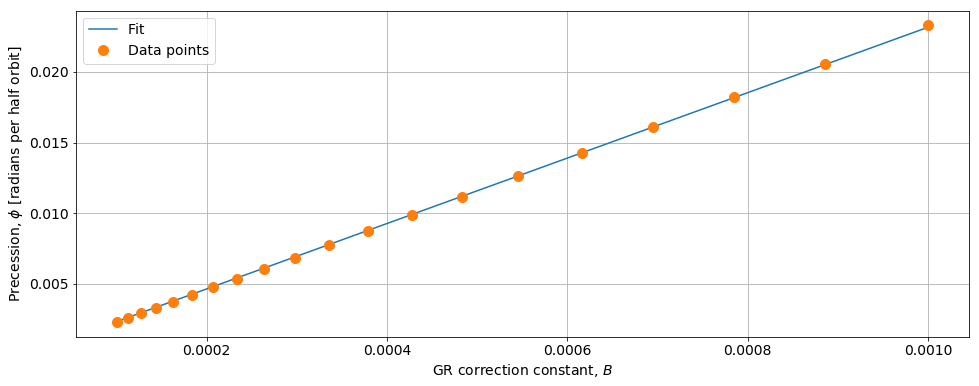

In [13]:
plt.figure()
plt.plot(B0, B0*popt[0], label="Fit")
plt.plot(B0, phi, "o", label="Data points")
plt.xlabel(r"GR correction constant, $B$")
plt.ylabel(r"Precession, $\phi$ [radians per half orbit]")
plt.legend()
plt.show()

In [14]:
print("Precession of Mercury is estimated to %.2f arcsec per century."
      % (r2aspc(B*popt[0])))

Precession of Mercury is estimated to 43.57 arcsec per century.


It can be shown that the precession rate is given by [2]

\begin{equation}
\delta \phi_\mathrm{prec}=\frac{6\pi G}{c^2}\frac{M}{a\left(1-\epsilon^2\right)}.
\end{equation}

The orbit eccentricity is $\epsilon=0.2056$ and the semi-major axis is $57.91\times 10^6\;\mathrm{km}$ [3].

In [15]:
epsilon = 0.2056
a = 57.91e9
dphi = 6*np.pi*G*M/(c**2*a*(1 - epsilon**2))
print("Precession of Mercury is approximately %.2f arcsec per century."
      % (dphi*100*3600/0.240846*180/np.pi))

Precession of Mercury is approximately 42.99 arcsec per century.


The expected result is $43$ arcsec. The results argree within two digits. This is as expected: both methods include several approximations, and in the numerical case, there exists some numerical rounding errors.

# Resources
[1] Kutner, M. (2003). Astronomy: A Physical Perspective. Cambridge: Cambridge University Press. doi:10.1017/CBO9780511802195  
[2] Hartle, J. B. Gravity: An Introduction to Einstein's General Relativity. San Francisco: Addison-Wesley, 2003.   
[3] NASA. Mercury Fact Sheet. URL: https://nssdc.gsfc.nasa.gov/planetary/factsheet/mercuryfact.html (accessed: Feb. 2018)

# Appendix: Fortran (95) code

```fortran

subroutine getOrbit(x, y, steps, z0, h, a, b)

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!! This code is used to compute the position of a planets position  !!
!! at aphelion (maximum) in the Schwarzschild geometry given        !!
!! initial positions and velocities. The code is described in       !!
!! detail (Python) in the General relativity notebook on            !!
!! numfys.net. The code can be compiled using F2PY.                 !!
!!                                                                  !!
!! Input:                                                           !!
!!    z0 : float, len(4). [x, y, u, v]. Initial x and y position    !!
!!         and initial velocity in x and y direction.               !!
!!    h  : float. Step length.                                      !!
!!    a  : float. Constant A (force strength).                      !!
!!    b  : float. Constant B (GR correction).                       !!
!! Output:                                                          !!
!!    x  : float. x position at next maximum.                       !!
!!    y  : float. y position at next maximum.                       !!
!!    steps: int. Number of steps used.                             !!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

implicit none

integer, intent(out)  :: steps
double precision, intent(out) :: x, y
double precision, intent(in) :: z0(4), a, b, h
double precision :: z(4), rho2, rhotemp

z = z0

rhotemp = 0
rho2 = z0(1)**2 + z0(2)**2
steps = 0

! Uses 4th order Runge-Kutta method to compute the position of the
! planet at each step. The mass distribution (Sun) is located around
! the origin. When the distance to the origin do not increase, we
! are at the maximum (aphelion).
do while (rho2 > rhotemp)
    rhotemp = rho2
    call rk4step(a, b, z, h)
    rho2 = z(1)**2 + z(2)**2
    steps = steps + 1
end do

x = z(1)
y = z(2)

return

contains

    ! Right hand side of EoM
    subroutine rhs(a, b, z, s)

        implicit none

        double precision, intent(in) :: z(4)
        double precision, intent(in)    :: a, b
        double precision, intent(out) :: s(4)
        double precision :: temp, rho

        rho = (z(1)**2 + z(2)**2)**.5
        temp = a/rho**3*(1 + B/rho**2)

        s(1) = z(3)
        s(2) = z(4)
        s(3) = - z(1)*temp
        s(4) = - z(2)*temp

        return

    end subroutine

    ! One step of Fourth-Order Runge-Kutta Method
    subroutine rk4step(a, b, z, h)

        implicit none

        double precision, intent(inout) :: z(4)
        double precision, intent(in) :: a, b, h
        double precision :: s1(4), s2(4), s3(4), s4(4)

        call rhs(a, b, z, s1)
        call rhs(a, b, z + h*s1/2.0, s2)
        call rhs(a, b, z + h*s2/2.0, s3)
        call rhs(a, b, z + h*s3, s4)

        z = z + h/6.0*(s1 + 2.0*s2 + 2.0*s3 + s4)

        return

    end subroutine

end subroutine

```